# Predictive maintenance

⚠️ Trong việc sử dụng các thiết bị động cơ, máy móc sẽ không thể tránh khỏi việc bị hư hỏng. Điều này gây tổn thất lớn trong các nhà máy, xí nghiệp. Có 2 hướng xử lí chính trong trường hợp này:

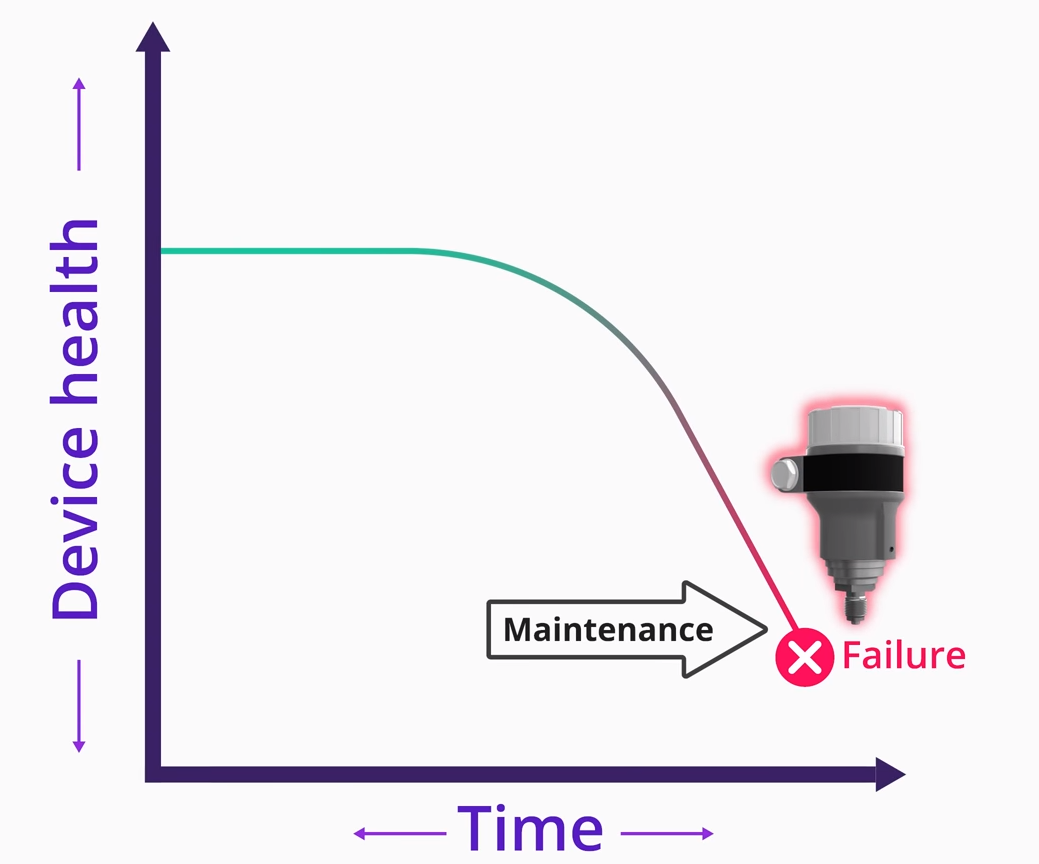

👉 Cách 1: Sử dụng đến khi thiết bị hỏng, rồi mới bảo trì:

<span style="color: green; font-size: 24px;">&#10004;</span> Đơn giản, không cần đề phòng

<span style="color:red">&#10060;</span> Khi thiết bị hỏng, chưa kịp chuẩn bị thiết bị thay thế để vận hành hệ thống, tình trạng bảo trì kéo dài, không thể vận hành hệ thống, **gây tổn thất lớn**

---

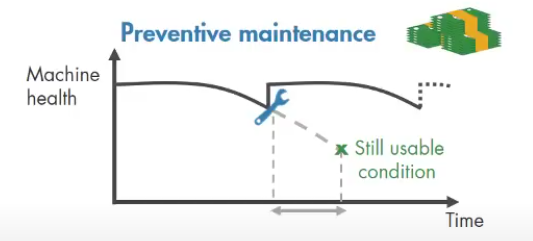

👉 Cách 2: Thay thế định kỳ, cố định thời gian hoặc là thay thế khi có bất kỳ lỗi gì xảy ra:

<span style="color: green; font-size: 24px;">&#10004;</span> Luôn đảm bảo hệ thống vận hành trơn tru, lỗi ít

<span style="color:red">&#10060;</span> Chi phí thay thế cao do thay thế sớm, không tận dụng được ` tối đa công suất của thiết bị ` gây lãng phí => **không tối ưu chi phí**

---

👉 Chính vì thế **Predictive maintenance** được nghiên cứu với mục đích tối ưu hiệu năng của thiết bị, giảm thiểu chi phí bảo trì:

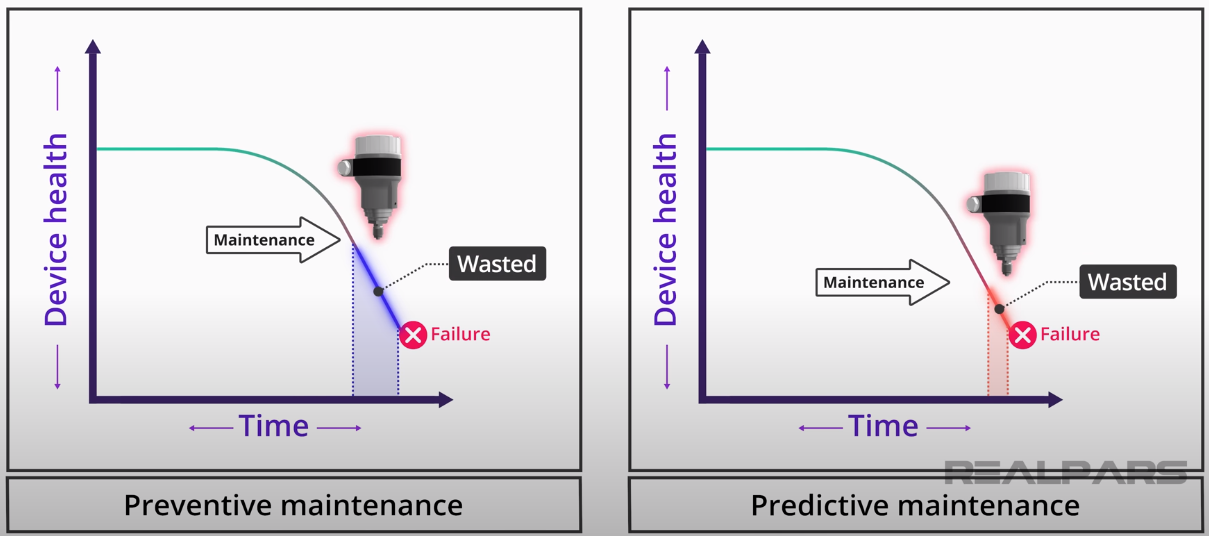

<span style="color: green; font-size: 24px;">&#10004;</span> Nắm bắt được thời điểm mà thiết bị hỏng, thay thế ngay trước khi thiết bị hỏng ,**kéo dài thời gian sử dụng** thiết bị => tối đa hóa hiệu năng của thiết bị

# Estimate Remaining Useful Life

**3 loại model dùng để dự đoán tuổi thọ**

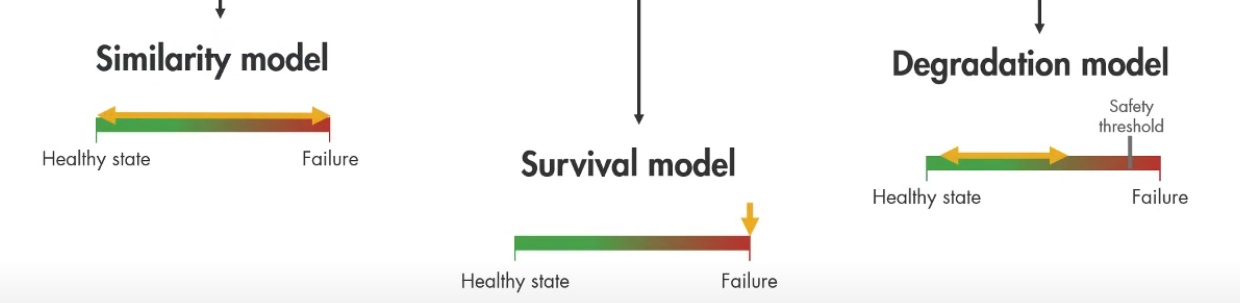

* Nếu có lịch sử hoàn chỉnh từ các bộ phận tương tự, có thể sử dụng **Similarity** để ước tính RUL
* Nếu chỉ có dữ liệu về thời điểm thất bại thi có thể sử dụng **Survival** model
* Nếu không có dữ liệu sẵn, tha có thể sử dụng kiến thực về ngưỡng an toàn(độ tin cậy) , ta có thể dùng **Degeadation Model**

# DATA

In [292]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.cluster import KMeans


In [293]:
DATA_PATH = 'data/'

---

👉 Bộ data bao gồm một `multivariate time series`

👉 Mỗi một thành phần `single time series` là một nhóm những động cơ khác nhau, cùng loại.


👉 Mỗi `động cơ` khởi động với một mức độ hao mòn và tuổi thọ khác nhau mà người dùng không thể biết trước

👉 Ngoài ra, bộ data chứa trong đó những `noise` của từng sensor

---

👉 Trong bộ training set, lỗi tăng dần cho đến khi hệ thống bị hỏng

👉 ở test set, chuỗi sẽ dừng lại trước một thời gian khi hệ thống lỗi

👉 Mỗi dòng của bộ data sẽ tương ứng với 1 chu kỳ hoạt động của hệ thống

<span style="color: green; font-size: 24px;">&#10004;</span> Bài toán sẽ là `predict` số lượng **chu kỳ hoạt động** còn lại trước khi bị hỏng

<span style="color: green; font-size: 24px;">&#10004;</span> Được cung cấp sẵn một vector về số lượng **chu kỳ hoạt động** còn lại của mỗi ID trong testdata

**Bao gồm 5 bộ phận quay: Fan, LPC, HPC, HPT, LPT**

INPUT informations:
* device_1 : Lưu lượng nhiên liệu

* device_2 : Bộ điều chỉnh hiệu suất **FAN**
* device_3 : Bộ điều chỉnh lưu lượng **FAN**
* device_4 : Bộ điều chỉnh tỉ lệ áp suất **FAN**

* device_5 : Bộ điều chỉnh hiệu suất **LPC**
* device_6 : Bộ điều chỉnh lưu lượng **LPC**
* device_7 : Bộ điều chỉnh tỉ lệ áp suất **LPC**

* device_8 : Bộ điều chỉnh hiệu suất **HPC**
* device_9 : Bộ điều chỉnh lưu lượng **HPC**
* device_10 : Bộ điều chỉnh tỉ lệ áp suất **HPC**

* device_11 : Bộ điều chỉnh hiệu suất **LPC**
* device_12: Bộ điều chỉnh lưu lượng **LPC**

* device_13 : Bộ điều chỉnh hiệu suất **LPT**
* device_14: Bộ điều chỉnh lưu lượng **HPT**

**Columns** informations:
* op_setting_1,op_setting_2,op_setting_3 : 3 cài đặt vận hành ảnh hưởng đáng kể đến động cơ
* sensor_1: Tổng nhiệt độ đầu vào FAN (độ R)
* sensor_2: Tổng nhiệt độ đầu ra LPC (độ R)
* sensor_3: Tổng nhiệt độ đầu ra HPC (độ R)
* sensor_4: Tổng nhiệt độ đầu ra LPT (độ R)
* sensor_5: Áp suất đầu vào quạt (psia)
* sensor_6: Tổng áp suất ống dẫn nhánh (psia)
* sensor_7: Tổng áp suất đầu ra HPC (psia)
* sensor_8: Tốc độ quạt (rpm)
* sensor_9: Tốc độ lõi (rpm)
* sensor_10: Tỷ lệ áp suất động cơ (P50/P2 tính theo sensor 5)
* sensor_11: Áp suất tĩnh tại đầu ra HPC
* sensor_12: Tỉ lệ lưu lượng nhiên liệu (Tính theo sensor 11)
* sensor_13: Tốc độ quạt được điều chỉnh
* sensor_14: Tốc độ lỗi được điều chỉnh
* sensor_15: Tỷ lệ bỏ qua
* sensor_16: Tỷ lệ nhiên liệu- không khí đốt
* sensor_17: Enthalpy rò rỉ
* sensor_18: Tốc độ quạt yêu cầu (rpm)
* sensor_19: Tốc độ lõi yêu cầu (rpm)
* sensor_20: Lưu lượng chất làm mát HPT(lbm/s)
* sensor_21: Lưu lượng chất làm mát LPT(lbm/s)


In [294]:
new_index_row = ['id','time','op_setting_1','op_setting_2','op_setting_3',
                 'sensor_1','sensor_2','sensor_3','sensor_4','sensor_5',
                 'sensor_6','sensor_7','sensor_8','sensor_9','sensor_10',
                 'sensor_11','sensor_12','sensor_13','sensor_14','sensor_15',
                 'sensor_16','sensor_17','sensor_18','sensor_19','sensor_20',
                 'sensor_21','sensor_22','sensor_23']

In [295]:
train_df = pd.read_csv(DATA_PATH + 'train_FD002.txt', names = new_index_row,sep=' ')
test_df = pd.read_csv(DATA_PATH + 'test_FD002.txt',names = new_index_row,sep=' ')

In [296]:
train_df = train_df.iloc[:,:-2]
test_df = test_df.iloc[:,:-2]

In [297]:
train_df

,id,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,...,314.05,2389.02,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,...,371.22,2388.42,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,...,163.74,2030.33,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,...,164.37,2030.35,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729


In [298]:
train_df['time'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [299]:
test_df

,id,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,371.69,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,315.32,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,183.04,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,130.40,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,164.56,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33986,259,119,35.0015,0.8403,100.0,449.44,555.56,1366.01,1129.47,5.48,...,183.05,2388.39,8088.36,9.3215,0.02,334,2223,100.00,14.94,8.9065
33987,259,120,42.0066,0.8405,100.0,445.00,549.42,1351.13,1123.86,3.91,...,130.74,2388.31,8108.48,9.3542,0.02,332,2212,100.00,10.57,6.4075
33988,259,121,42.0061,0.8400,100.0,445.00,549.65,1349.14,1118.91,3.91,...,130.96,2388.34,8098.77,9.3836,0.02,331,2212,100.00,10.57,6.4805
33989,259,122,0.0024,0.0003,100.0,518.67,642.58,1589.61,1408.16,14.62,...,522.25,2388.00,8161.85,8.4279,0.03,393,2388,100.00,39.08,23.3589


In [300]:
# EDA

In [301]:
age = train_df.groupby(by='id').count().iloc[:,0]

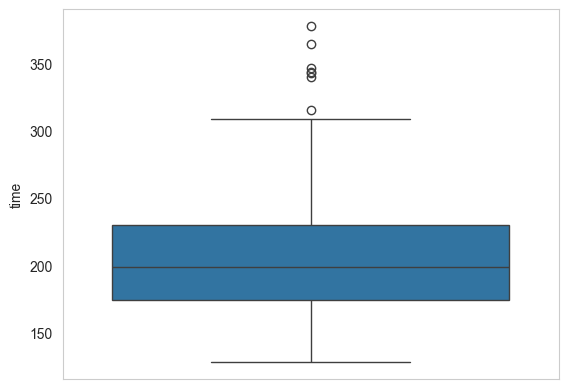

In [302]:
sns.boxplot(y=age);

In [303]:
corr_matrix = train_df.iloc[:,1:].corr()

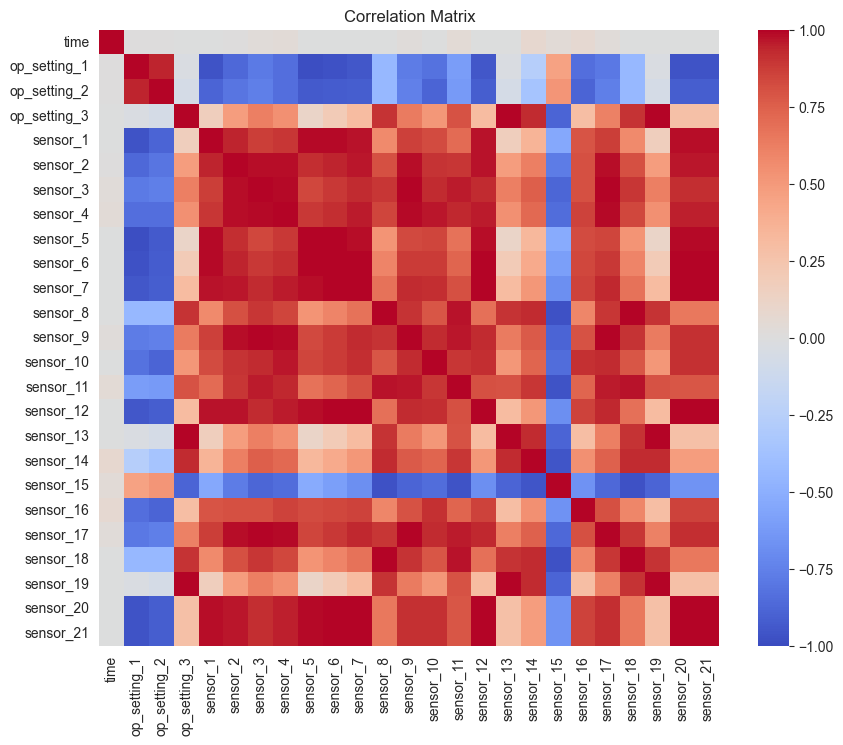

In [304]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

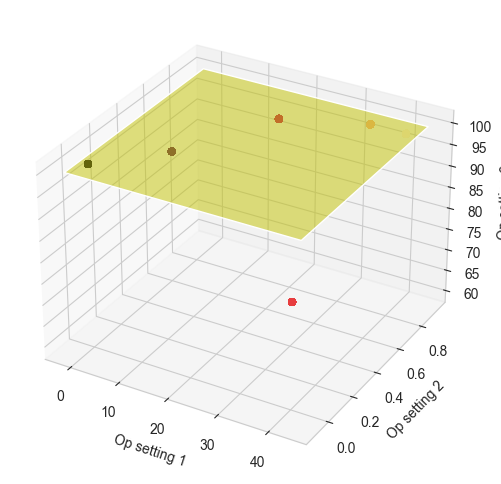

In [305]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,10))

# ax = Axes3D(fig) # Method 1
ax = fig.add_subplot(111, projection='3d') # Method 2

x = train_df['op_setting_1']
y = train_df['op_setting_2']
z = train_df['op_setting_3']

X, Y = np.meshgrid(np.linspace(x.min()-2, x.max()+2, 10), np.linspace(y.min()-0.1, y.max()+0.1, 10))
Z = np.full_like(X, 100)

# Vẽ mặt phẳng
ax.plot_surface(X, Y, Z, alpha=0.5, rstride=100, cstride=100, color='yellow')
ax.scatter(x, y, z, c=x, marker='o')
ax.set_xlabel('Op setting 1')
ax.set_ylabel('Op setting 2')
ax.set_zlabel('Op setting 3')

plt.show();

In [306]:
kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto")

In [307]:
op_setting_df = train_df.iloc[:,2:5]

In [308]:
kmeans.fit(op_setting_df)
kmeans.cluster_centers_

array([[4.20029763e+01, 8.40485184e-01, 1.00000000e+02],
       [1.00029713e+01, 2.50495035e-01, 1.00000000e+02],
       [2.50030380e+01, 6.20501875e-01, 6.00000000e+01],
       [1.50451268e-03, 4.94343610e-04, 1.00000000e+02],
       [3.50030490e+01, 8.40500585e-01, 1.00000000e+02],
       [2.00029990e+01, 7.00515193e-01, 1.00000000e+02]])

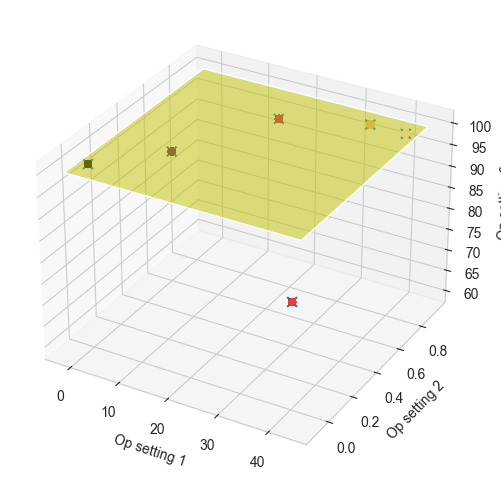

In [309]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,10))

# ax = Axes3D(fig) # Method 1
ax = fig.add_subplot(111, projection='3d') # Method 2

x = train_df['op_setting_1']
y = train_df['op_setting_2']
z = train_df['op_setting_3']
centroids = kmeans.cluster_centers_
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
centroids_z = centroids[:,2]

X, Y = np.meshgrid(np.linspace(x.min()-2, x.max()+2, 10), np.linspace(y.min()-0.1, y.max()+0.1, 10))
Z = np.full_like(X, 100)

# Vẽ mặt phẳng
ax.plot_surface(X, Y, Z, alpha=0.5, rstride=100, cstride=100, color='yellow')

ax.scatter(centroids_x, centroids_y, centroids_z, marker='x',s=50,alpha=1)
ax.scatter(x, y, z, c=x, marker='o')
ax.set_xlabel('Op setting 1')
ax.set_ylabel('Op setting 2')
ax.set_zlabel('Op setting 3')

plt.show();

## Normalize

In [310]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_df.iloc[:,5:])

train_df.iloc[:,5:] = scaler.transform(train_df.iloc[:,5:])

In [311]:
train_df

,id,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,34.9983,0.8400,100.0,-0.889378,-0.653071,-0.579176,-0.572622,-0.706177,...,-0.603008,0.415116,-0.212615,0.021948,-0.705933,-0.515579,-0.039954,0.418187,-0.613958,-0.619148
1,1,2,41.9982,0.8408,100.0,-1.057627,-0.798422,-0.630051,-0.668741,-1.140622,...,-0.985404,0.414648,0.067215,0.063719,-0.705933,-0.659701,-0.115645,0.418187,-1.051681,-1.048190
2,1,3,24.9988,0.6218,60.0,-0.392968,-1.136055,-1.540521,-1.326301,-0.271732,...,-0.739869,-2.393490,-2.377822,2.087798,-0.705933,-1.416342,-2.159318,-2.391275,-0.679819,-0.641912
3,1,4,42.0077,0.8416,100.0,-1.057627,-0.808881,-0.622406,-0.663705,-1.140622,...,-0.983225,0.414257,0.024309,0.030890,-0.705933,-0.695731,-0.115645,0.418187,-1.033443,-1.013808
4,1,5,25.0005,0.6203,60.0,-0.392968,-1.142491,-1.531554,-1.322271,-0.271732,...,-0.739215,-2.393724,-2.420728,2.090734,-0.705933,-1.416342,-2.159318,-2.391275,-0.674753,-0.666180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,0.692693,0.780862,0.713849,0.537834,0.364716,...,0.348551,0.425267,1.214589,-0.034903,1.416565,0.745489,0.655032,0.418187,0.361801,0.345429
53755,260,313,10.0022,0.2510,100.0,0.611600,0.700946,0.890544,0.996270,0.688475,...,0.763855,0.420582,2.107123,-0.762087,1.416565,0.925641,0.620627,0.418187,0.740757,0.755203
53756,260,314,25.0041,0.6200,60.0,-0.392968,-1.131496,-1.356652,-1.238408,-0.271732,...,-0.743356,-2.375530,-1.123891,2.316803,-0.705933,-1.380311,-2.159318,-2.391275,-0.668673,-0.662515
53757,260,315,25.0033,0.6220,60.0,-0.392968,-1.121841,-1.387706,-1.168060,-0.271732,...,-0.738779,-2.375374,-1.109510,2.300789,-0.705933,-1.344281,-2.159318,-2.391275,-0.682859,-0.692473


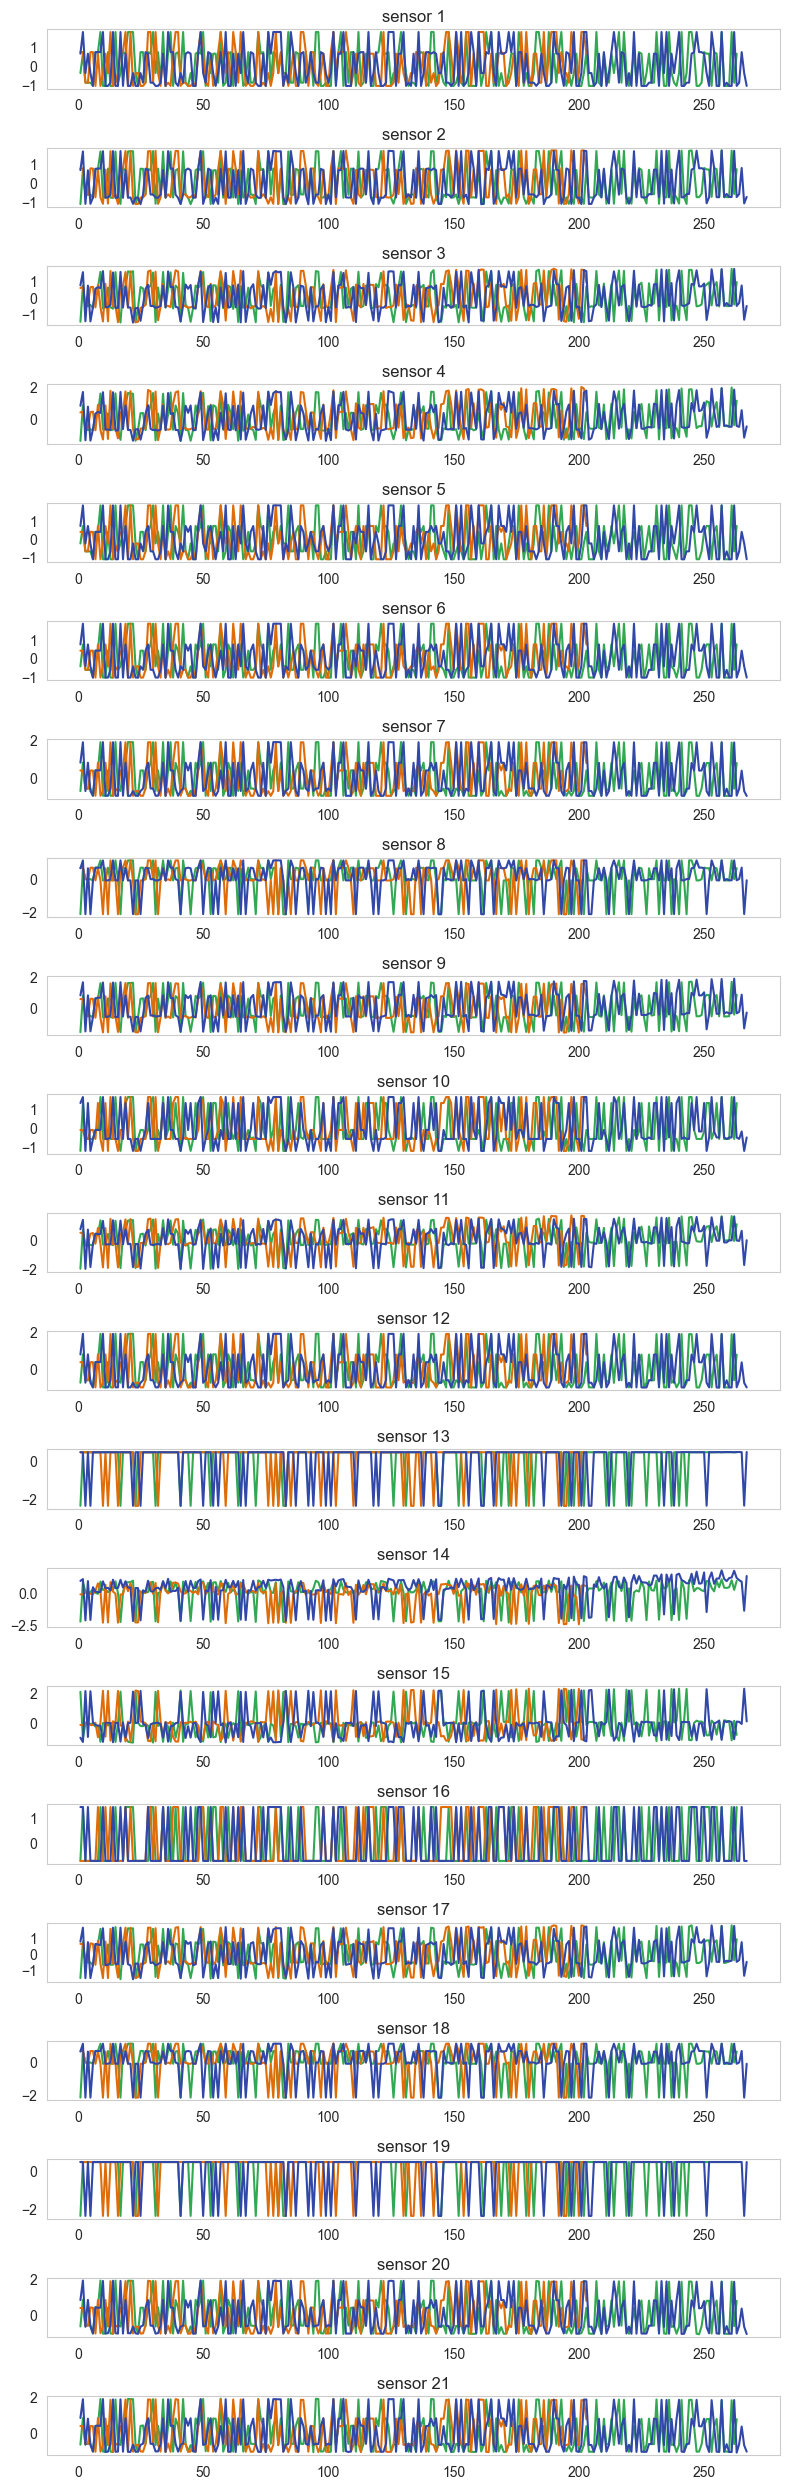

In [312]:
fig,axs = plt.subplots(nrows=21,ncols=1,figsize=(8,25))

random_id = np.random.randint(1,260,3)
df_id = train_df[train_df['id'].isin(random_id)]
colors = ['#32a852','#de6c09','#3248a8']
for i in range(21):
    for j,id_ in enumerate(random_id):
        color = colors[j % 3]
        df_sensor = df_id[df_id['id']==id_].iloc[:,[1,i+5]]
        df_sensor.set_index('time',inplace=True)
        axs[i].plot(df_sensor,color=color)
    axs[i].set_title(f'sensor {i+1}')
plt.tight_layout()


# Survival function

## Exponential survival function (common use)

(Phân phối mũ)

* Hàm mật độ xác suất:

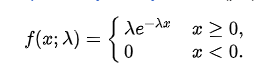

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/Exponential_distribution_pdf_-_public_domain.svg/1280px-Exponential_distribution_pdf_-_public_domain.svg.png' style="width:500px;"/> 

* Tuy nhiên hàm này có nhược điểm là tính chất **Không nhớ**, tức là không quan tâm tuổi thọ là bao nhiêu, tỷ lệ chết của thiết bị lâu năm và thiết bị mới là như nhau

## Log-logisitc distribution

* Hàm mật độ xác suất

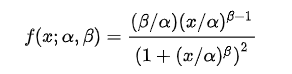

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/Loglogisticpdf.svg/1280px-Loglogisticpdf.svg.png' style="width:500px;"/> 

$\alpha = 1, \beta$ shown in legend

## Gamma distribution

* Hàm mật độ xác suất

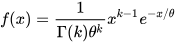

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Gamma_distribution_pdf.svg/1280px-Gamma_distribution_pdf.svg.png' style="width:500px;"/> 

## Hypertabastic survival function

/*hai pơ ta bát s tích*/

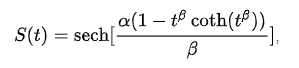

* Trong đó $S(t)$ là xác suất thời gian có thể vượt quá t

<img src='https://upload.wikimedia.org/wikipedia/commons/7/7e/Hypertabastic_survival_function_curves.png' style="width:500px;"/> 

reference: https://en.wikipedia.org/wiki/Hypertabastic_survival_models#Hypertabastic_survival_function

## Age

In [314]:
age = train_df.groupby(by='id').count().iloc[:,0].rename('Age')

In [318]:
train_df = train_df.join(age,on='id')
train_df['RUL'] = train_df['Age'] - train_df['time']

,id,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,Age,RUL
0,1,1,34.9983,0.8400,100.0,-0.889378,-0.653071,-0.579176,-0.572622,-0.706177,...,-0.212615,0.021948,-0.705933,-0.515579,-0.039954,0.418187,-0.613958,-0.619148,149,148
1,1,2,41.9982,0.8408,100.0,-1.057627,-0.798422,-0.630051,-0.668741,-1.140622,...,0.067215,0.063719,-0.705933,-0.659701,-0.115645,0.418187,-1.051681,-1.048190,149,147
2,1,3,24.9988,0.6218,60.0,-0.392968,-1.136055,-1.540521,-1.326301,-0.271732,...,-2.377822,2.087798,-0.705933,-1.416342,-2.159318,-2.391275,-0.679819,-0.641912,149,146
3,1,4,42.0077,0.8416,100.0,-1.057627,-0.808881,-0.622406,-0.663705,-1.140622,...,0.024309,0.030890,-0.705933,-0.695731,-0.115645,0.418187,-1.033443,-1.013808,149,145
4,1,5,25.0005,0.6203,60.0,-0.392968,-1.142491,-1.531554,-1.322271,-0.271732,...,-2.420728,2.090734,-0.705933,-1.416342,-2.159318,-2.391275,-0.674753,-0.666180,149,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,0.692693,0.780862,0.713849,0.537834,0.364716,...,1.214589,-0.034903,1.416565,0.745489,0.655032,0.418187,0.361801,0.345429,316,4
53755,260,313,10.0022,0.2510,100.0,0.611600,0.700946,0.890544,0.996270,0.688475,...,2.107123,-0.762087,1.416565,0.925641,0.620627,0.418187,0.740757,0.755203,316,3
53756,260,314,25.0041,0.6200,60.0,-0.392968,-1.131496,-1.356652,-1.238408,-0.271732,...,-1.123891,2.316803,-0.705933,-1.380311,-2.159318,-2.391275,-0.668673,-0.662515,316,2
53757,260,315,25.0033,0.6220,60.0,-0.392968,-1.121841,-1.387706,-1.168060,-0.271732,...,-1.109510,2.300789,-0.705933,-1.344281,-2.159318,-2.391275,-0.682859,-0.692473,316,1


In [352]:
train_df['time'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

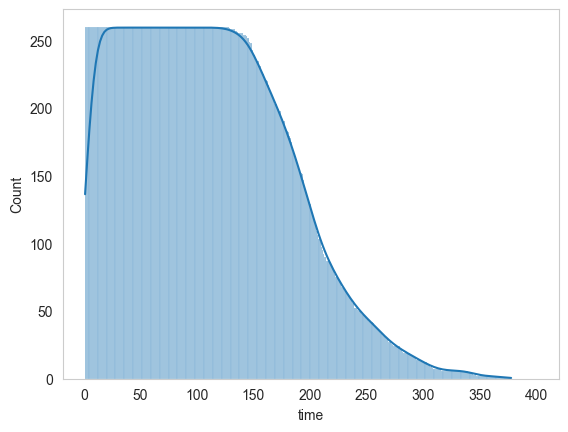

In [389]:
sns.histplot(data=train_df['time'],bins=400,kde=True,binrange=(1,400));

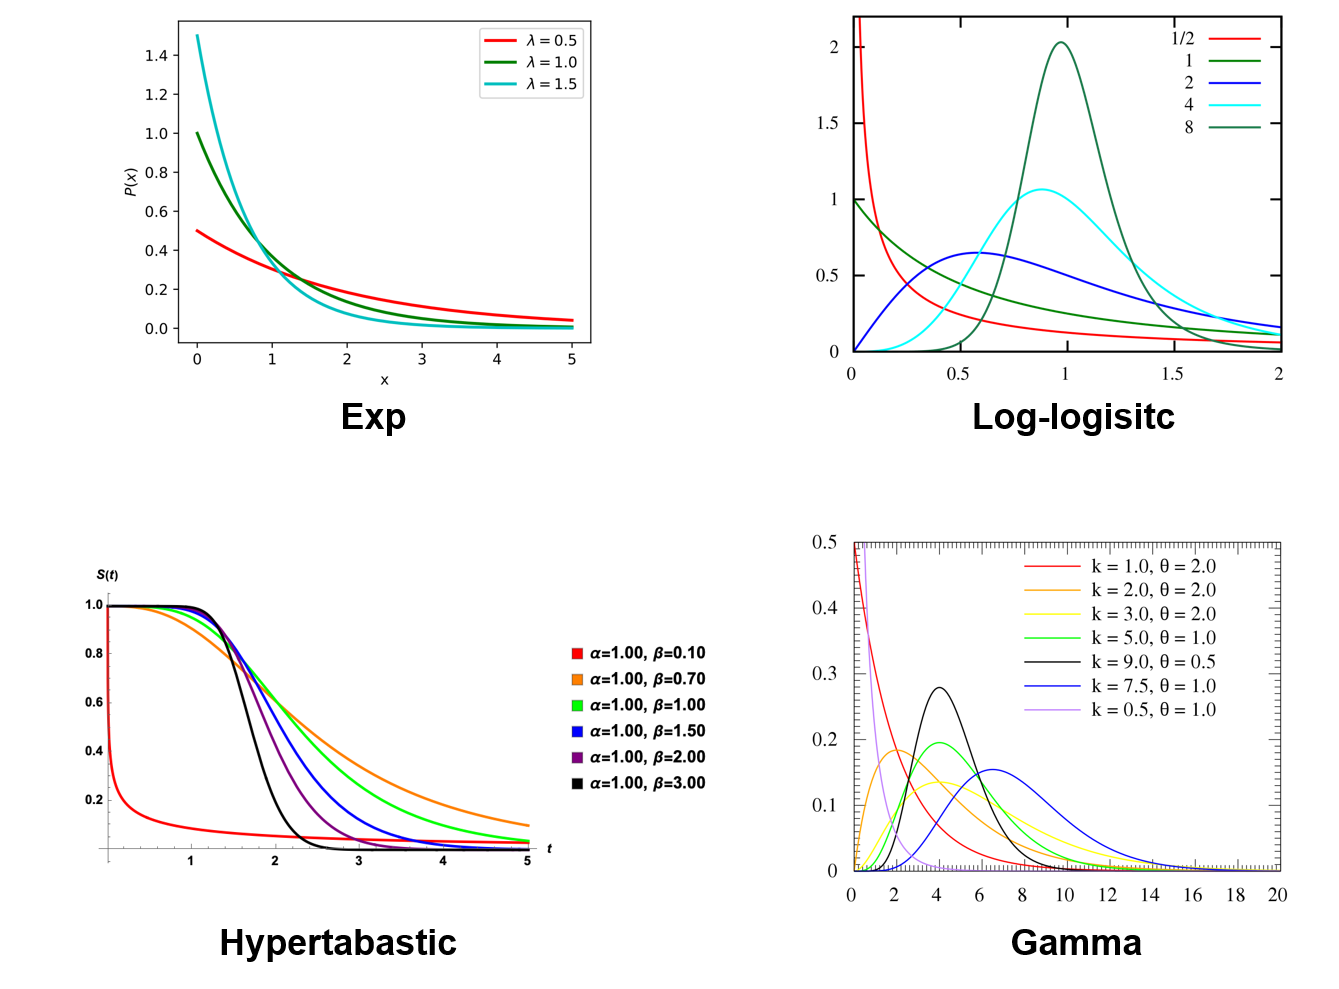

# Fit distribution

- Ta sẽ tìm một **phân phối thể hiện xác suất chết theo tuổi** để ước lượng **health indicator** cho từng id trong tập train  

(tức là độ hao mòn hay độ hỏng dần của các id đều có xu hướng giảm như nhau, chỉ khác nhau là nhanh hay chậm theo khoảng thời gian, đồ thị lao xuống phải có dáng dấp như nhau)

## Age distribution

👉 Plot phân phối xác suất tại thời điểm t (trục x), và xác suất máy còn sống sau thời gian t ($P(T>t)$) (trục y)

**Count age per id**

In [404]:
count_age = train_df.groupby(by='time').count().iloc[:,:1]
count_age.rename(columns={'id':'num_id'},inplace=True)
count_age

,num_id
time,
1,260
2,260
3,260
4,260
5,260
...,...
374,1
375,1
376,1


**Count frequency**

In [411]:
count_age['freq'] = count_age['num_id']/260
count_age.drop(columns='num_id',inplace=True)
count_age

,freq
time,
1,1.000000
2,1.000000
3,1.000000
4,1.000000
5,1.000000
...,...
374,0.003846
375,0.003846
376,0.003846


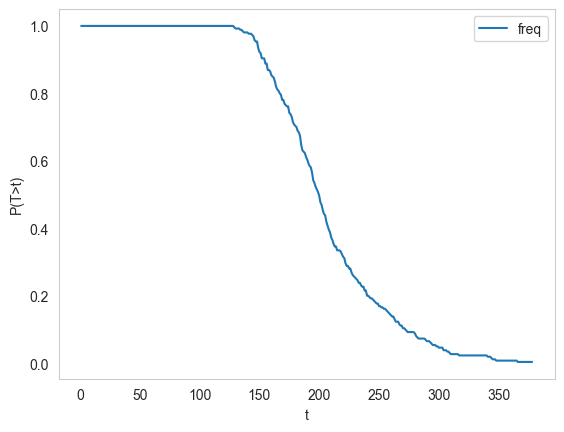

In [414]:
count_age.plot(ylabel='P(T>t)',xlabel='t');

👉 TIME in range (1,400)

In [419]:
x = np.linspace(1,400,400)

<span style="color: green; font-size: 24px;">&#10004;</span> Từ đây ta được phân phối theo yêu cầu: <font size=5> $P(T>t)$


## Biến đổi 

### <span style="color: blue;"> **Hàm mật độ xác suất**</span>

**(probability density function): PDF**

👉<span style="color: blue;"> **Hàm mật độ xác suất**</span> của biến ngẫu nhiên liên tục $X$là hàm $f(X)$ *thể hiện xác suất trong 1 khoảng*:
    
* $f(x) \geq 0 $ $ \forall  x$
* $ \int_{-\infty}^{\infty} f(x)dx = 1$
* $P(X \in B) = \int_B f(x)dx$ hay $P(A < X < B) = \int_A^B f(x)dx$


### <span style="color: green;"> **Hàm phân phối xác suất**</span>

**(cumulative distribution function): CDF**

👉 Để không cần phải tính tích phân khi tính xác suất, ta sẽ sử dụng <span style="color: green;"> **Hàm phân phối xác suất**</span>: **$F(x)$** thay thế bởi:
* $F(x) = P(X<x) = \int_{-\infty}^x f(t)dt$

<span style="color: green;"> **Hàm phân phối xác suất**</span> Khác với hàm mật độ xác suất là tính **tổng tích lũy** xác suất nhỏ hơn x cho trước

&#128161; Nhưng điều ta cần tính là $P(T>t)$☝ nên cần một chút biến đổi:

$F(x) = P(X<x)$ 👉 $1 - F(x) = 1 - P(X<x) = P(X>x) $<span style="color: green; font-size: 24px;">&#10004;</span> 

<font size=5> Từ giờ, ta sẽ lấy **hàm sống sót** (survival function): **S(t) = 1 - P(T>t)**

## Exp

In [422]:
def cdf_Exp(x,lbda):
    if x.any() < 0:
        return 0
    return 1-np.exp(-(lbda*x))
def s_Exp(x,lbda):
    return 1 - cdf_Exp(x,lbda)

In [434]:
x = np.linspace(0,2,100)

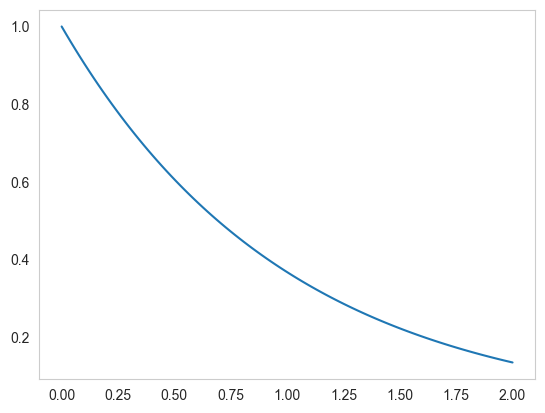

In [436]:
plot(x,s_Exp(x,1));

## Log-logistic 

In [361]:
def log_logistic(x,alpha,beta):
    above = (beta/alpha)*((x/alpha)**(beta-1))
    beneath = (1+(x/alpha)**beta)**2
    return above/beneath

In [ ]:
x_log_logistic_scaled = x/

# Sử dụng phân phối nào đó (scale X(health indicator) hợp lý theo phân phối đó) để fit với Age distribution của data

<span style="color:red">&#10060;</span> : X

👉 👇 ☝


⚠️

<span style="color: green; font-size: 24px;">&#10004;</span>
: Dấu tích

&#128161; : bóng đèn

<font size =5> &#x1F9EE; Công thức 

<font size =5> &#x1F4DA; : Bài tập
   
<img src='link' style="width:500px;"/> : Chèn ảnh
    
<div style="margin-left: 200px;">: căn lề
    
    
<span style="color: color;"> **text**</span> : màu